# Cross Comparison of Multiple Search Results

This notebook provides the functionality of comparing identification results from different search engines,
and showing the new discoveries produced by Xolik.

## Import libraries and define importing functions

In [27]:
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
from matplotlib_venn import venn3_unweighted
%matplotlib inline


def read_plink_result(filename):

    data = pd.read_csv(filename, sep='\t', skiprows=[0])
    first_half = data[data.index % 2 == 0]
    first_half.columns = ['#', 'Spectrum', 'PeptideNum', 'UniquePepNum', 'Samples', 'Score', 'Condition', 
                          'S', 'SS', 'SSS']
    first_half = first_half.reset_index()
    first_half = first_half.drop(['index', 'S', 'SS', 'SSS'], axis=1)
    second_half = data[data.index % 2 == 1]
    second_half = second_half.reset_index()
    second_half = second_half.drop(['index', 'Score'], axis=1)
    data = pd.concat([first_half, second_half], axis=1)

    data['PeptideNum'] = data['PeptideNum'].astype(int)
    if len(data[data['PeptideNum'] > 1]) > 0:
        raise Exception('Existing multiple match for one spectrum')
    data = data.drop(['PeptideNum', 'UniquePepNum', 'Samples', 'Condition', '#', '*', '#,Spec', 'SampleID'], axis=1)
    
    def extract_scan_num(spec_name):
        words = spec_name.split('.')
        return int(words[1])

    data['ScanNum'] = data['Spectrum'].apply(extract_scan_num)

    def split_link(pname):
        pname = pname.split(':')[0]
        words = pname.split('-')
        fwords = words[0].split('(')
        alpha = fwords[0]
        alpha_site = int(fwords[1][:-1])
        swords = words[1].split('(')
        beta = swords[0]
        beta_site = int(swords[1][:-1])
        return alpha, alpha_site, beta, beta_site

    def get_alpha(pname):
        (alpha, alpha_site, beta, beta_site) = split_link(pname)
        return alpha

    def get_alpha_site(pname):
        (alpha, alpha_site, beta, beta_site) = split_link(pname)
        return alpha_site

    def get_beta(pname):
        (alpha, alpha_site, beta, beta_site) = split_link(pname)
        return beta

    def get_beta_site(pname):
        (alpha, alpha_site, beta, beta_site) = split_link(pname)
        return beta_site

    data['Peptide#1'] = data['Peptide'].apply(get_alpha)
    data['LinkSite#1'] = data['Peptide'].apply(get_alpha_site)
    data['Peptide#2'] = data['Peptide'].apply(get_beta)
    data['LinkSite#2'] = data['Peptide'].apply(get_beta_site)
    data['Protein#1'] = data['Proteins'].apply(get_alpha)
    data['Protein#2'] = data['Proteins'].apply(get_beta)

    data = data.drop(['Mod_Sites', 'Calc_M', 'Delta_M', 'ppm', 'Peptide', 'Proteins'], axis=1)
    
    return data


def split_kojak_peptide(row):
    record = row['Peptide']
    middle = record.split('.')[1]
    words = middle.split('--')
    pep1 = words[0][:-1]
    pep2 = words[1][:-1]
    pep1_words = pep1.split('(')
    seq1 = pep1_words[0]
    site1 = int(pep1_words[1])
    pep2_words = pep2.split('(')
    seq2 = pep2_words[0]
    site2 = int(pep2_words[1])
    row['Peptide#1'] = seq1
    row['LinkSite#1'] = site1
    row['Peptide#2'] = seq2
    row['LinkSite#2'] = site2
    return row

## Load data and build statistic data structure

In [28]:
path_prefix = r'../../Exp2/26Syeast/'
frames = []

for fileindex in ['004', '005', '006', '007']:
    plink = read_plink_result(
        path_prefix + r'pLink/file{}.dir/2.report/sample1/aleitner_inter_combine.spectra.xls'.format(fileindex))
    plink_intra = plink[plink['Protein#1'] == plink['Protein#2']]
    plink_inter = plink[plink['Protein#1'] != plink['Protein#2']]
    
    kojak_intra = pd.read_csv(path_prefix + r'Kojak/aleitner_M1012_{}.perc.intra.txt.controlled.csv'.format(fileindex))
    kojak_inter = pd.read_csv(path_prefix + r'Kojak/aleitner_M1012_{}.perc.inter.txt.controlled.csv'.format(fileindex))
    kojak_intra = kojak_intra[kojak_intra['qValue'] <= 0.05]
    kojak_inter = kojak_inter[kojak_inter['qValue'] <= 0.05]
    kojak_intra = kojak_intra.apply(split_kojak_peptide, axis=1)
    kojak_inter = kojak_inter.apply(split_kojak_peptide, axis=1)
    kojak_intra['ScanNum'] = kojak_intra['scannr']
    kojak_inter['ScanNum'] = kojak_inter['scannr']

    xolik_intra = pd.read_csv(path_prefix + r'Xolik-new/{}.csv.intra.filtered.csv'.format(fileindex))
    xolik_inter = pd.read_csv(path_prefix + r'Xolik-new/{}.csv.inter.filtered.csv'.format(fileindex))
    xolik_intra = xolik_intra[xolik_intra['qValue'] <= 0.05]
    xolik_inter = xolik_inter[xolik_inter['qValue'] <= 0.05]
    xolik_intra['LinkSite#1'] = xolik_intra['LinkSite#1'] + 1
    xolik_intra['LinkSite#2'] = xolik_intra['LinkSite#2'] + 1
    xolik_inter['LinkSite#1'] = xolik_inter['LinkSite#1'] + 1
    xolik_inter['LinkSite#2'] = xolik_inter['LinkSite#2'] + 1
    xolik_intra['Peptide#1'] = xolik_intra['Peptide#1'].apply(lambda x: x.split('.')[1])
    xolik_intra['Peptide#2'] = xolik_intra['Peptide#2'].apply(lambda x: x.split('.')[1])
    xolik_inter['Peptide#1'] = xolik_inter['Peptide#1'].apply(lambda x: x.split('.')[1])
    xolik_inter['Peptide#2'] = xolik_inter['Peptide#2'].apply(lambda x: x.split('.')[1])

    # build dataframes in unified structure
    def build_dataframe(data, engine_name, attribute, filename):
        df = pd.DataFrame(data[['ScanNum', 'Peptide#1', 'LinkSite#1', 'Peptide#2', 'LinkSite#2', 
                                'Protein#1', 'Protein#2', 'Score']])
        df['Attribute'] = attribute
        df.insert(0, 'File', filename)
        df.insert(2, 'Engine', engine_name)
        return df
    
    frames.append(build_dataframe(plink_intra, 'pLink', 'intra', fileindex))
    frames.append(build_dataframe(plink_inter, 'pLink', 'inter', fileindex))
    frames.append(build_dataframe(kojak_intra, 'Kojak', 'intra', fileindex))
    frames.append(build_dataframe(kojak_inter, 'Kojak', 'inter', fileindex))
    frames.append(build_dataframe(xolik_intra, 'Xolik', 'intra', fileindex))
    frames.append(build_dataframe(xolik_inter, 'Xolik', 'inter', fileindex))
    
records = pd.concat(frames)
records = records.reset_index()
records = records.drop(['index'], axis=1)

def adjust_and_clean(row):
    seq1 = row['Peptide#1']
    seq2 = row['Peptide#2']
    site1 = row['LinkSite#1']
    site2 = row['LinkSite#2']
    pro1 = row['Protein#1']
    pro2 = row['Protein#2']
    seq1 = seq1.replace('I', 'L')
    seq2 = seq2.replace('I', 'L')
    if seq1 > seq2 or (seq1 == seq2 and site1 > site2):
        seq1, seq2 = seq2, seq1
        site1, site2 = site2, site1
        pro1, pro2 = pro2, pro1
    pro1 = '|'.join(pro1.split('|')[:2])
    pro2 = '|'.join(pro2.split('|')[:2])
    row['Peptide#1'] = seq1
    row['Peptide#2'] = seq2
    row['LinkSite#1'] = site1
    row['LinkSite#2'] = site2
    row['Protein#1'] = pro1
    row['Protein#2'] = pro2
    return row

records = records.apply(adjust_and_clean, axis=1)

## Statistics of Identified Spectra

Collect statistics and draw Venn diagram in spectrum level.

In [29]:
def get_flag(subset):  # flag value: 1=plink, 2=kojak, 3=xolik, 4=p+k, 5=p+x, 6=k+x, 7=p+k+x
    if len(subset[subset['Engine'] == 'pLink']) > 0:
        if len(subset[subset['Engine'] == 'Kojak']) > 0:
            return 7 if len(subset[subset['Engine'] == 'Xolik']) > 0 else 4
        else:
            return 5 if len(subset[subset['Engine'] == 'Xolik']) > 0 else 1
    else:
        if len(subset[subset['Engine'] == 'Kojak']) > 0:
            return 6 if len(subset[subset['Engine'] == 'Xolik']) > 0 else 2
        else:
            return 3 if len(subset[subset['Engine'] == 'Xolik']) > 0 else 0

def draw_venn_diagram(input_dict):
    plink_own = len([value for value in input_dict.values() if value == 1])
    kojak_own = len([value for value in input_dict.values() if value == 2])
    xolik_own = len([value for value in input_dict.values() if value == 3])
    pk_overlap = len([value for value in input_dict.values() if value == 4])
    px_overlap = len([value for value in input_dict.values() if value == 5])
    kx_overlap = len([value for value in input_dict.values() if value == 6])
    pkx_overlap = len([value for value in input_dict.values() if value == 7])

    # draw Venn diagram
    venn3_unweighted(subsets=(plink_own, kojak_own, pk_overlap, xolik_own, px_overlap, kx_overlap, pkx_overlap), 
                     set_labels=('pLink', 'Kojak', 'Xolik'))

def boolean_merge(one, another):
    if one > another:
        one, another = another, one
    if one == 1:
        if another in [1, 4, 5, 7]:
            return another
        elif another == 2:
            return 4
        elif another == 3:
            return 5
        elif another == 6:
            return 7
    elif one == 2:
        if another in [2, 4, 6, 7]:
            return another
        elif another == 3:
            return 6
        elif another == 5:
            return 7
    elif one == 3:
        return another if another in [3, 5, 6, 7] else 7  # 4
    elif one == 4:
        return 7 if another in [5, 6, 7] else 4
    elif one == 5:
        return 5 if another == 5 else 7
    elif one == 6:
        return 6 if another == 6 else 7
    else:
        return 7

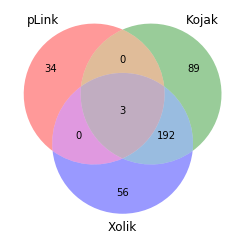

In [30]:
spectra_dict = dict()  # index by file+scan_num
for fileindex in records['File'].unique():
    file_subset = records[records['File'] == fileindex]
    for scan_num in file_subset['ScanNum'].unique():
        subset = file_subset[file_subset['ScanNum'] == scan_num]
        flag = get_flag(subset)
        spectra_dict[fileindex+'-'+str(scan_num)] = flag

draw_venn_diagram(spectra_dict)

## Statistics of Peptide-Spectral Matches

Collect statistics at PSM level.

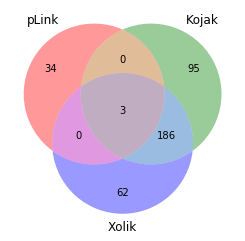

In [31]:
psm_dict = dict()  # index by file+scan_num
for fileindex in records['File'].unique():
    file_subset = records[records['File'] == fileindex]
    for scan_num in file_subset['ScanNum'].unique():
        scan_subset = file_subset[file_subset['ScanNum'] == scan_num]
        for p1 in scan_subset['Peptide#1'].unique():
            p1_subset = scan_subset[scan_subset['Peptide#1'] == p1]
            for p2 in p1_subset['Peptide#2'].unique():
                p2_subset = p1_subset[p1_subset['Peptide#2'] == p2]
                flag = get_flag(p2_subset)
                psm_dict[fileindex+'-'+str(scan_num)+'-'+p1+'-'+p2] = flag

draw_venn_diagram(psm_dict)
#plt.savefig('venn_psm.eps', format='eps')

## Statistics of Peptide-Spectral Matches + Link Sites

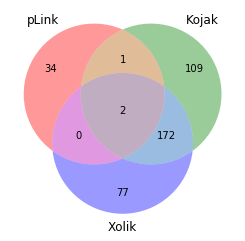

In [32]:
psm_site_dict = dict()  # index by file+scan_num
for fileindex in records['File'].unique():
    file_subset = records[records['File'] == fileindex]
    for scan_num in file_subset['ScanNum'].unique():
        scan_subset = file_subset[file_subset['ScanNum'] == scan_num]
        for p1 in scan_subset['Peptide#1'].unique():
            p1_subset = scan_subset[scan_subset['Peptide#1'] == p1]
            for p2 in p1_subset['Peptide#2'].unique():
                p2_subset = p1_subset[p1_subset['Peptide#2'] == p2]
                for l1 in p2_subset['LinkSite#1'].unique():
                    l1_subset = p2_subset[p2_subset['LinkSite#1'] == l1]
                    for l2 in l1_subset['LinkSite#2'].unique():
                        l2_subset = l1_subset[l1_subset['LinkSite#2'] == l2]
                        flag = get_flag(l2_subset)
                        psm_site_dict[fileindex+'-'+str(scan_num)+'-'+p1+'-'+p2+'-'+str(l1)+'-'+str(l2)] = flag

draw_venn_diagram(psm_site_dict)

## Statistics of Identified Peptides + Link Sites

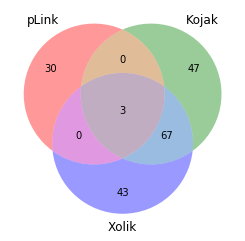

In [33]:
peptide_site_dict = dict()  # index by file+scan_num
for p1 in records['Peptide#1'].unique():
    p1_subset = records[records['Peptide#1'] == p1]
    for p2 in p1_subset['Peptide#2'].unique():
        p2_subset = p1_subset[p1_subset['Peptide#2'] == p2]
        for l1 in p2_subset['LinkSite#1'].unique():
            l1_subset = p2_subset[p2_subset['LinkSite#1'] == l1]
            for l2 in l1_subset['LinkSite#2'].unique():
                l2_subset = l1_subset[l1_subset['LinkSite#2'] == l2]
                flag = get_flag(l2_subset)
                entry = p1+'-'+p2+'-'+str(l1)+'-'+str(l2)
                if entry in peptide_site_dict:
                    previous = peptide_site_dict[entry]
                    new_flag = boolean_merge(previous, flag)
                    peptide_site_dict[entry] = new_flag
                else:
                    peptide_site_dict[p1+'-'+p2+'-'+str(l1)+'-'+str(l2)] = flag

draw_venn_diagram(peptide_site_dict)
#plt.savefig('venn_ps.eps', format='eps')

## Statistics of Identified Peptides

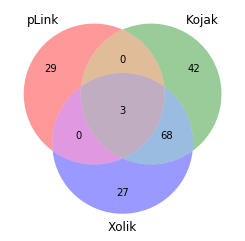

In [34]:
peptide_dict = dict()  # index by file+scan_num
for p1 in records['Peptide#1'].unique():
    p1_subset = records[records['Peptide#1'] == p1]
    for p2 in p1_subset['Peptide#2'].unique():
        p2_subset = p1_subset[p1_subset['Peptide#2'] == p2]
        flag = get_flag(p2_subset)
        entry = p1+'-'+p2
        if entry in peptide_dict:
            new_flag = boolean_merge(peptide_dict[entry], flag)
            peptide_dict[entry] = new_flag
        else:
            peptide_dict[p1+'-'+p2] = flag

draw_venn_diagram(peptide_dict)
#plt.savefig('venn_p.eps', format='eps')

## Playground

In [35]:
frames = []
for p1 in records['Peptide#1'].unique():
    p1_subset = records[records['Peptide#1'] == p1]
    for p2 in p1_subset['Peptide#2'].unique():
        p2_subset = p1_subset[p1_subset['Peptide#2'] == p2]
        for l1 in p2_subset['LinkSite#1'].unique():
            l1_subset = p2_subset[p2_subset['LinkSite#1'] == l1]
            for l2 in l1_subset['LinkSite#2'].unique():
                l2_subset = l1_subset[l1_subset['LinkSite#2'] == l2]
                flag = get_flag(l2_subset)
                if flag == 3:
                    frames.append(l2_subset)
                    
xolik_unique_ps = pd.concat(frames)

In [36]:
xolik_unique_ps[xolik_unique_ps['Attribute'] == 'inter']

,File,ScanNum,Engine,Peptide#1,LinkSite#1,Peptide#2,LinkSite#2,Protein#1,Protein#2,Score,Attribute


In [37]:
fileindex = '006'
xolik_intra = pd.read_csv(path_prefix + r'Xolik-new/{}.csv.intra.filtered.csv'.format(fileindex))
xolik_inter = pd.read_csv(path_prefix + r'Xolik-new/{}.csv.inter.filtered.csv'.format(fileindex))
xolik_intra = xolik_intra[xolik_intra['qValue'] <= 0.05]
xolik_inter = xolik_inter[xolik_inter['qValue'] <= 0.05]

xolik_inter[xolik_inter['ScanNum'].isin(xolik_unique_ps['ScanNum'])]

,ScanNum,Score,Peptide#1,LinkSite#1,Protein#1,Score#1,Peptide#2,LinkSite#2,Protein#2,Score#2,qValue


In [38]:
xolik_unique_raw = xolik_inter[xolik_inter['ScanNum'].isin(xolik_unique_ps['ScanNum'])]

In [39]:
scores = pd.concat([xolik_unique_raw['Score#1'], xolik_unique_raw['Score#2']])
len(scores[scores < 0.2])

0